In [1]:
import pandas as pd
import numpy as np
import pandas

from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.integrate import quad

from astropy.io import fits
from astropy.table import Table

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Spectrum of the galaxy
data = Table.read('lrg.fits', format='fits')
df = data.to_pandas()
df['FREQUENCY'] = 2.99792458e18 / df['LAMBDA'].values

def spectrum_data(df, z):
    df['OBSERVED_FREQUENCY'] = df['FREQUENCY'].values/(1+z)
    return df

In [3]:
def read_passband(band, z):
    """                                                                                                                                                                                                                                                                                                                                                                        
    Read and interpolate filter transmission curves                                                                                                                                                                                                                                                                                                                             

    :param band: the single-letter band identifier                                                                                                                                                                                                                                                                                                                             
    :return: transmisison_frequency: interpolated filter transmission as a function of frequency                                                                                                                                                                                                                                                                               
    :return: transmisison_wavelength: interpolated filter transmission as a function of wavelength                                                                                                                                                                                                                                                                             
    """
    #Target filter file associated with band                                                                                                                                                                                                                                                                                                                                   
    filter_file = 'filters/DECam_{}.dat'.format(band)  #[x for x in self.filter_files if x.find('_' + band) != -1][0]

    # Read and format filter transmission info                                                                                                                                                                                                                                                                                                                                 
    passband = pd.read_csv(filter_file,
                           names=['WAVELENGTH', 'TRANSMISSION'],
                           delim_whitespace=True, comment='#')

    # Add boundary terms to cover the whole range                                                                                                                                                                                                                                                                                                                              
    passband.loc[passband.shape[0]] = (1.e-1, 0.0)
    passband.loc[passband.shape[0]] = (4.e+4, 0.0)

    # Convert to frequency using speed of light in angstroms                                                                                                                                                                                                                                                                                                                   
    passband['FREQUENCY'] = 2.99792458e18 / passband['WAVELENGTH'].values
    passband['OBSERVED_FREQUENCY'] = passband['FREQUENCY'].values/(1+z)

    # Interpolate and return                                                                                                                                                                                                                                                                                                                                                   
    transmission_frequency = interp1d(passband['FREQUENCY'].values, passband['TRANSMISSION'].values, fill_value=0.0)
    transmission_frequency_obs = interp1d(passband['OBSERVED_FREQUENCY'].values, passband['TRANSMISSION'].values, fill_value=0.0)
    
    return transmission_frequency, transmission_frequency_obs

In [4]:
def k_correction(z , band, df):
    df = spectrum_data(df, z)

    transmission_frequency, transmission_frequency_obs = read_passband(band, z)
    transmission_f = transmission_frequency(df['FREQUENCY'].values)
    transmission_f_o = transmission_frequency_obs(df['OBSERVED_FREQUENCY'].values)

    first_term_integrant = (df['FLAMBDA'].values * transmission_f_o)/ df['OBSERVED_FREQUENCY'].values
    first_term_integrant_interpolated = interp1d(df['OBSERVED_FREQUENCY'].values, first_term_integrant)
    first_term = quad(first_term_integrant_interpolated, df['OBSERVED_FREQUENCY'].values[0], df['OBSERVED_FREQUENCY'].values[-1])[0]

    fourth_term_integrant = (df['FLAMBDA'].values * transmission_f)/ df['FREQUENCY'].values
    fourth_term_integrant_interpolated = interp1d(df['FREQUENCY'].values, fourth_term_integrant)
    fourth_term = quad(fourth_term_integrant_interpolated, df['FREQUENCY'].values[0], df['FREQUENCY'].values[-1])[0]

    k = -2.5*np.log10( (1+z) * (first_term/fourth_term) )
    return k

In [5]:
passbands = ['g', 'i', 'r', 'z']
for b in passbands:
    redshifts = np.linspace(0,4,1000)
    data = []
    for z in redshifts:
        data.append([z, k_correction(z, b, df)])
    data = pd.DataFrame(data)
    data.to_csv('k_values/{}_passband.csv'.format(b), sep = '\t')

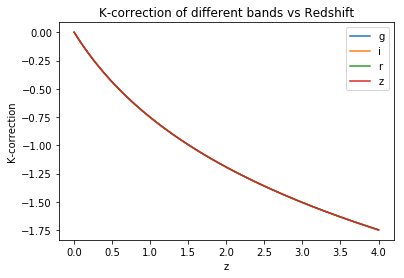

In [6]:
# Ploting the result from the files 
plt.figure()
plt.title('K-correction of different bands vs Redshift')
plt.xlabel('z')
plt.ylabel('K-correction')
for b in passbands:
    filter_file = 'k_values/{}_passband.csv'.format(b)
    k_correction = pd.read_csv(filter_file, names=['r', 'z', 'k'],
                           delim_whitespace=True, comment='#')
    plt.plot(k_correction['z'].values[1:], k_correction['k'].values[1:],
            label = '{}'.format(b))
plt.legend()
plt.show()